<a href="https://colab.research.google.com/github/saghar-trade/Time-series/blob/main/VARMA_Temperature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

!pip install -U statsmodels





In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt


from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [4]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/temperature.csv'  )
df.tail()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,record_id,month,day,year,AverageTemperatureFahr,AverageTemperatureUncertaintyFahr,City,country_id,Country,Latitude,Longitude
48465,8258726,5,1,2013,55.0544,32.4896,Wroclaw,POL,Poland,50.63N,16.48E
48466,8258727,6,1,2013,61.1672,32.3330,Wroclaw,POL,Poland,50.63N,16.48E
48467,8258728,7,1,2013,66.7706,32.5706,Wroclaw,POL,Poland,50.63N,16.48E
48468,8258729,8,1,2013,64.5656,32.4842,Wroclaw,POL,Poland,50.63N,16.48E
48469,8258730,9,1,2013,NaN,NaN,Wroclaw,POL,Poland,50.63N,16.48E


In [5]:
def parse_dates(row):
  s=f"{row['year']}{-row['month']}-{row['day']}"
  return datetime.strptime(s,'%Y-%m-%d')


In [6]:
df['Date']=df.apply(parse_dates, axis=1)


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48470 entries, 0 to 48469
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   record_id                          48470 non-null  int64         
 1   month                              48470 non-null  int64         
 2   day                                48470 non-null  int64         
 3   year                               48470 non-null  int64         
 4   AverageTemperatureFahr             47541 non-null  float64       
 5   AverageTemperatureUncertaintyFahr  47541 non-null  float64       
 6   City                               47986 non-null  object        
 7   country_id                         47986 non-null  object        
 8   Country                            47986 non-null  object        
 9   Latitude                           48470 non-null  object        
 10  Longitude                         

In [8]:
df.groupby("City").apply(lambda g: g.isna().sum(axis=1).sum())

/tmp/ipython-input-2993347988.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("City").apply(lambda g: g.isna().sum(axis=1).sum())


,0
City,
Auckland,12
Brasília,166
Canoas,170
Cape Town,16
Hamilton,2
Johannesburg,16
Kherson,140
Kiev,144
Lvov,146


In [9]:
auckland=df[df['City']=='Auckland'].copy().dropna()
stockholm=df[df['City']=='Stockholm'].copy().dropna()

In [10]:
#keep only columns we want
Auckland=auckland[['Date','AverageTemperatureFahr']].copy()
Stockholm=stockholm[['Date','AverageTemperatureFahr']].copy()

In [11]:
#set index to date col
Auckland.set_index(Auckland['Date'],inplace=True)
Auckland.drop('Date', axis=1, inplace=True)
Auckland.columns=['AuklandTem']



In [12]:

Stockholm.set_index(Stockholm['Date'],inplace=True)
Stockholm.drop('Date', axis=1, inplace=True)
Stockholm.columns=['StockholmTem']

In [13]:
joined=Auckland.join(Stockholm, how='outer')

In [14]:
joined_apart=joined.iloc[-500:].copy()
joined_apart.index.freq='MS'
joined_apart.isna().sum()


,0
AuklandTem,1
StockholmTem,4


In [15]:
joined_apart.interpolate(inplace=True)   #dont do this with stock
joined_apart.isna().sum()

,0
AuklandTem,0
StockholmTem,0


<Axes: xlabel='Date'>

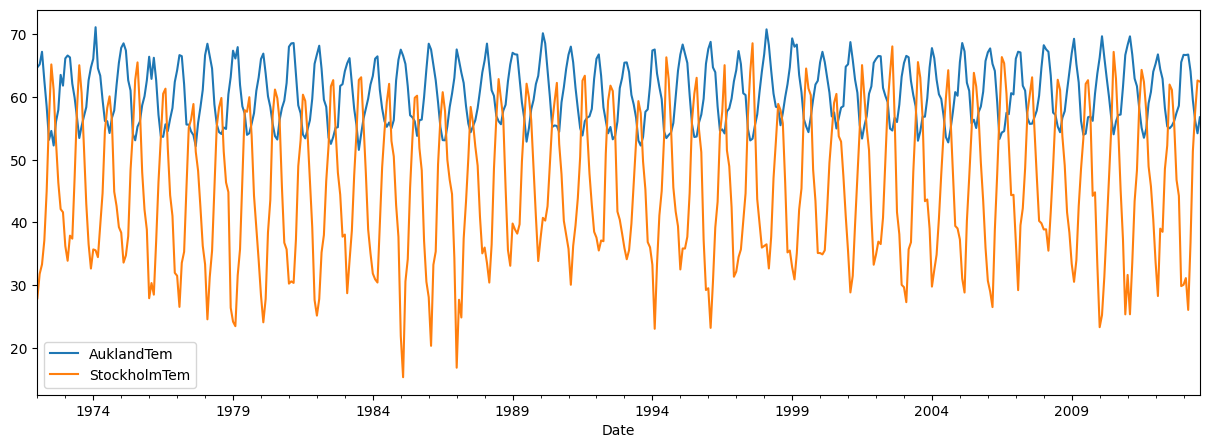

In [16]:
joined_apart.plot(figsize=(15,5))

In [17]:
Ntest=12
train=joined_apart[:-Ntest].copy()
test=joined_apart[-Ntest:].copy()

In [18]:
scaler_auckland=StandardScaler()
train['ScaledAuckland']=scaler_auckland.fit_transform(train[['AuklandTem']])
test['ScaledAuckland']=scaler_auckland.transform(test[['AuklandTem']])


In [19]:
scaler_stockholm=StandardScaler()
train['ScaledStockholm']=scaler_stockholm.fit_transform(train[['StockholmTem']])
test['ScaledStockholm']=scaler_stockholm.transform(test[['StockholmTem']])

In [20]:
train_idx=joined_apart.index <= train.index[-1]
test_idx=joined_apart.index > train.index[-1]

In [21]:
joined_apart.loc[train_idx,'ScaledAuckland']=train['ScaledAuckland']
joined_apart.loc[test_idx,'ScaledAuckland']=test['ScaledAuckland']
joined_apart.loc[train_idx,'ScaledStockholm']=train['ScaledStockholm']
joined_apart.loc[test_idx,'ScaledStockholm']=test['ScaledStockholm']

<Axes: xlabel='Date'>

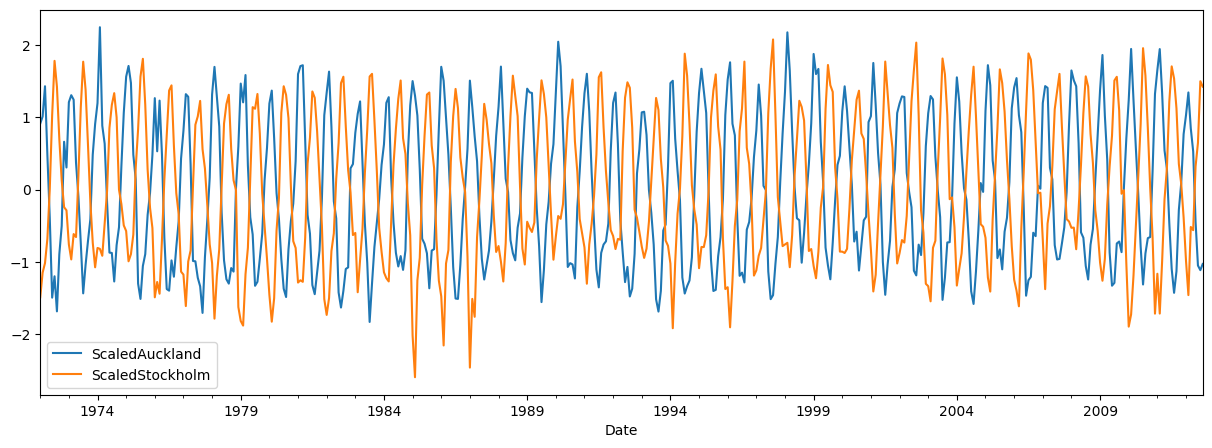

In [22]:
cols=['ScaledAuckland','ScaledStockholm']
train[cols].plot(figsize=(15,5))

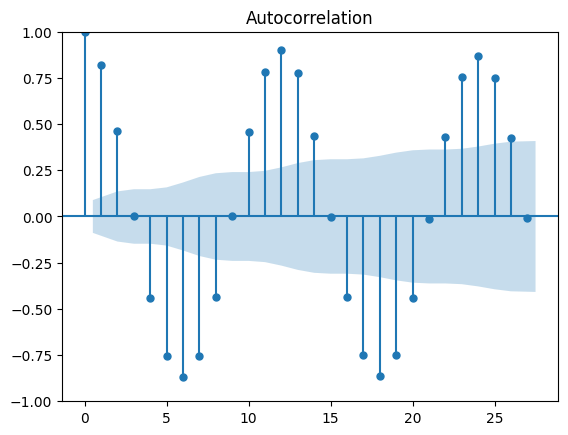

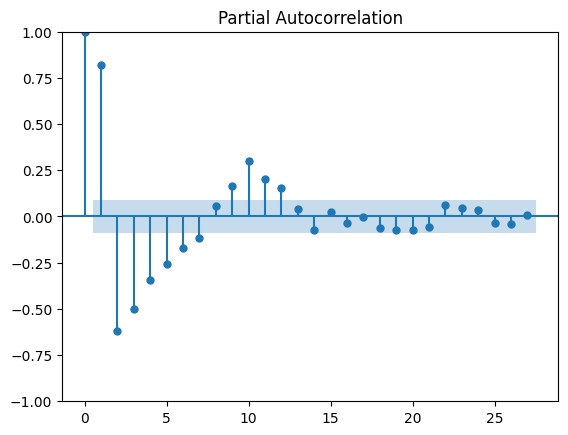

In [23]:
plot_acf(train['ScaledAuckland']);
plot_pacf(train['ScaledAuckland']);

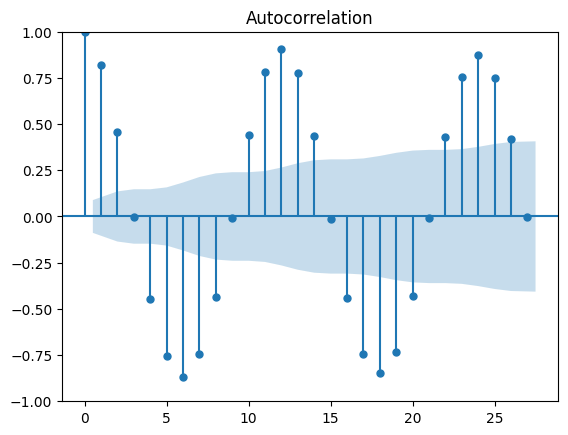

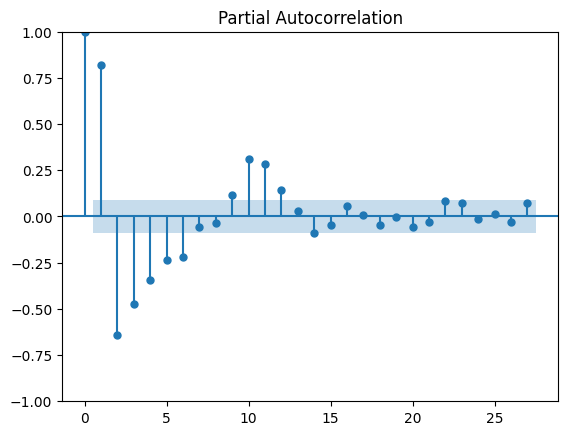

In [24]:

plot_acf(train['ScaledStockholm']);
plot_pacf(train['ScaledStockholm']);


In [25]:
t0=datetime.now()
model=VARMAX(train[cols], order=(10,10))
res=model.fit(maxiter=100)
print("Duration: ", datetime.now()-t0)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Duration:  0:04:58.561242


In [26]:
fcast=res.get_forecast(Ntest)

In [28]:
joined_apart.loc[train_idx, 'Train_pred_Auckland']=res.fittedvalues['ScaledAuckland']
joined_apart.loc[test_idx, 'Test_pred_Auckland']=fcast.predicted_mean['ScaledAuckland']

<Axes: xlabel='Date'>

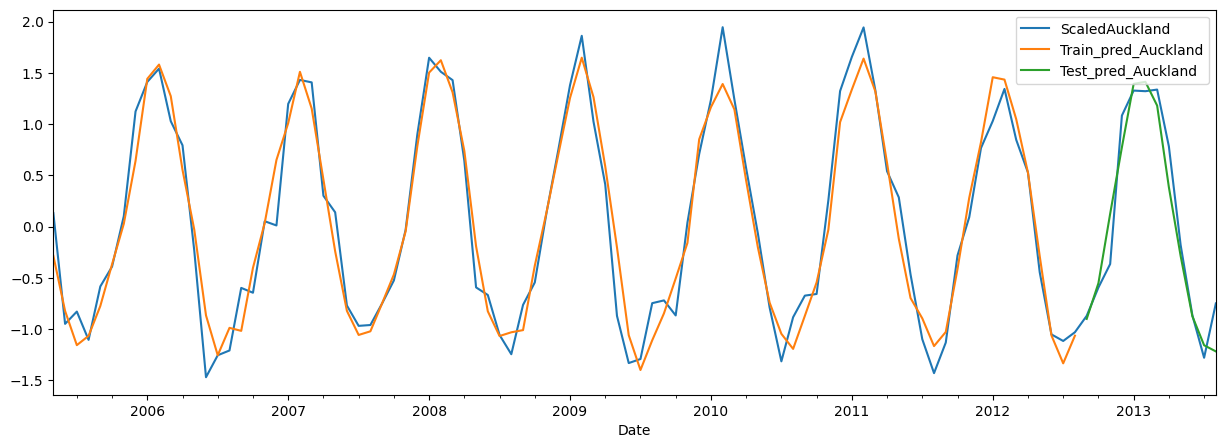

In [31]:
plot_cols=['ScaledAuckland','Train_pred_Auckland','Test_pred_Auckland']
joined_apart.iloc[-100:][plot_cols].plot(figsize=(15,5))

In [32]:
joined_apart.loc[train_idx, 'Train_pred_Stockholm']=res.fittedvalues['ScaledStockholm']
joined_apart.loc[test_idx, 'Test_pred_Stockholm']=fcast.predicted_mean['ScaledStockholm']

<Axes: xlabel='Date'>

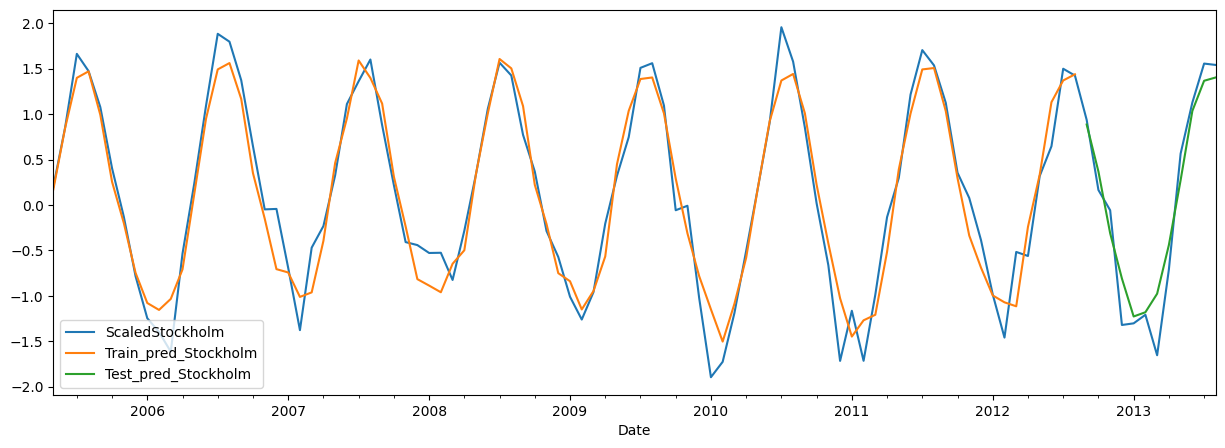

In [33]:
plot_cols=['ScaledStockholm','Train_pred_Stockholm','Test_pred_Stockholm']
joined_apart.iloc[-100:][plot_cols].plot(figsize=(15,5))

In [34]:
y_pred=joined_apart.loc[train_idx, 'Train_pred_Auckland']
y_true=joined_apart.loc[train_idx, 'ScaledAuckland']
print('Auckland Train R^2 :', r2_score(y_true,y_pred))

Auckland Train R^2 : 0.9295649900096992


In [35]:
y_pred=joined_apart.loc[test_idx, 'Test_pred_Auckland']
y_true=joined_apart.loc[test_idx, 'ScaledAuckland']
print('Auckland Test R^2 :', r2_score(y_true,y_pred))

Auckland Test R^2 : 0.9305070891888304


In [36]:
y_pred=joined_apart.loc[train_idx, 'Train_pred_Stockholm']
y_true=joined_apart.loc[train_idx, 'ScaledStockholm']
print('Stockholm Train R^2 :', r2_score(y_true,y_pred))

Stockholm Train R^2 : 0.9246532645158789


In [37]:
y_pred=joined_apart.loc[test_idx, 'Test_pred_Stockholm']
y_true=joined_apart.loc[test_idx, 'ScaledStockholm']
print('Stockholm Test R^2 :', r2_score(y_true,y_pred))

Stockholm Test R^2 : 0.9314893094244591


######VAR

In [39]:
model_v=VAR(train[cols])


In [40]:
lag_order_results=model_v.select_order(maxlags=15)
lag_order_results

In [41]:
lag_order_results.selected_orders

{'aic': np.int64(12),
 'bic': np.int64(6),
 'hqic': np.int64(11),
 'fpe': np.int64(12)}

In [42]:
results=model_v.fit(maxlags=15,ic='aic')

In [45]:
lag_order=results.k_ar
prior=train.iloc[-lag_order:][cols].to_numpy()
fcast=results.forecast(prior, Ntest)

In [48]:
joined_apart.loc[train_idx, 'Train_pred_Auckland']=results.fittedvalues['ScaledAuckland']
joined_apart.loc[test_idx, 'Test_pred_Auckland']=fcast[:,0]

<Axes: xlabel='Date'>

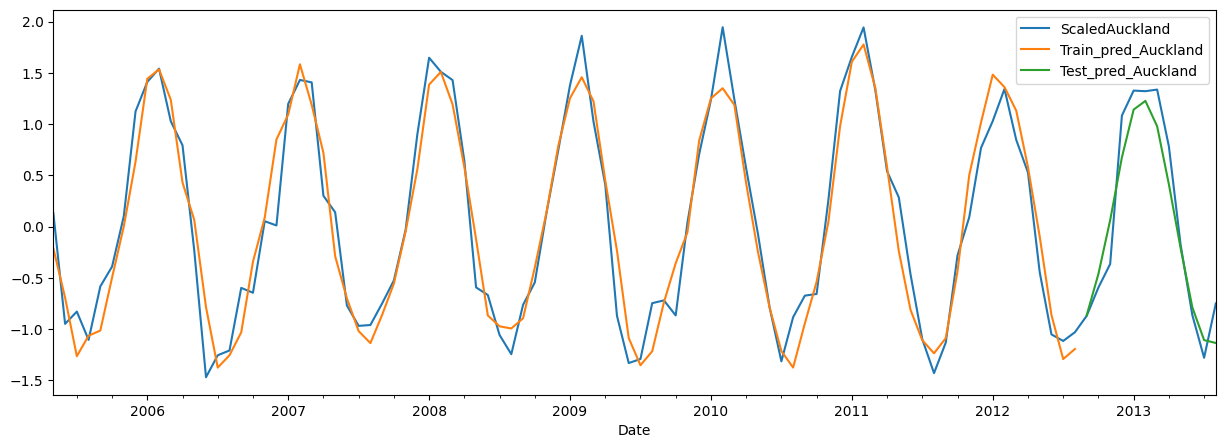

In [49]:
plot_cols=['ScaledAuckland','Train_pred_Auckland','Test_pred_Auckland']
joined_apart.iloc[-100:][plot_cols].plot(figsize=(15,5))

In [50]:
joined_apart.loc[train_idx, 'Train_pred_Stockholm']=results.fittedvalues['ScaledStockholm']
joined_apart.loc[test_idx, 'Test_pred_Stockholm']=fcast[:,1]

<Axes: xlabel='Date'>

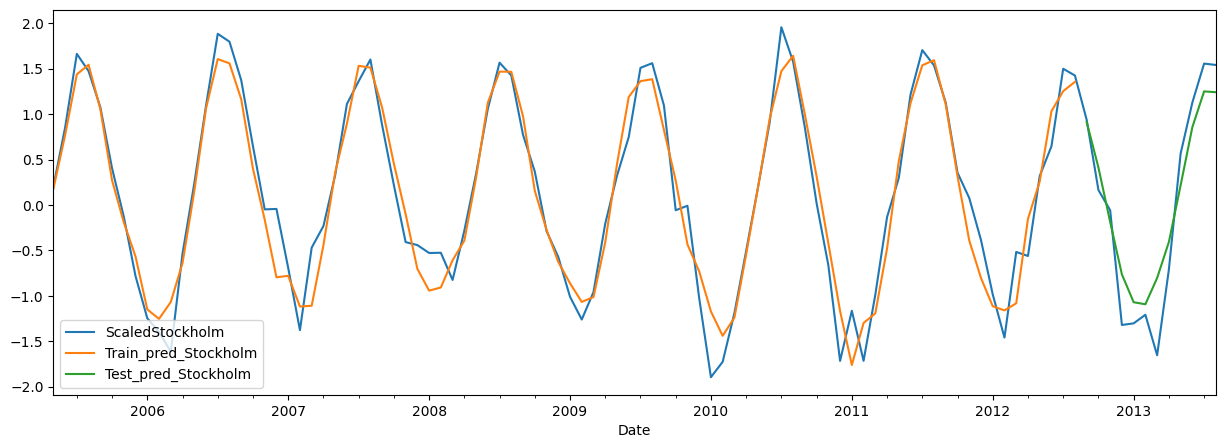

In [53]:
plot_cols=['ScaledStockholm','Train_pred_Stockholm','Test_pred_Stockholm']
joined_apart.iloc[-100:][plot_cols].plot(figsize=(15,5))

In [60]:
y_pred=joined_apart.loc[train_idx, 'Train_pred_Auckland']
y_pred.iloc[lag_order:]

y_true=joined_apart.loc[train_idx, 'ScaledAuckland']
y_true.iloc[lag_order:]
#ignoring nan values
mask = ~y_true.isna() & ~np.isnan(y_pred)
r2 = r2_score(y_true[mask], y_pred[mask])
print('Auckland Train R^2 :', r2)

Auckland Train R^2 : 0.921070700106029


In [57]:
y_pred=joined_apart.loc[test_idx, 'Test_pred_Auckland']
y_true=joined_apart.loc[test_idx, 'ScaledAuckland']
print('Auckland Test R^2 :', r2_score(y_true,y_pred))

Auckland Test R^2 : 0.9233643831340895


In [61]:
y_pred=joined_apart.loc[train_idx, 'Train_pred_Stockholm']
y_pred.iloc[lag_order:]

y_true=joined_apart.loc[train_idx, 'ScaledStockholm']
y_true.iloc[lag_order:]
#ignoring nan values
mask = ~y_true.isna() & ~np.isnan(y_pred)
r2 = r2_score(y_true[mask], y_pred[mask])
print('Stockholm Train R^2 :', r2)

Stockholm Train R^2 : 0.9267030553588321


In [62]:
y_pred=joined_apart.loc[test_idx, 'Test_pred_Stockholm']
y_true=joined_apart.loc[test_idx, 'ScaledStockholm']
print('Stockholm Test R^2 :', r2_score(y_true,y_pred))

Stockholm Test R^2 : 0.8930437688204875


####ARIMA BASELINE

In [63]:
from statsmodels.tsa.arima.model import ARIMA

In [66]:
for col in cols:
  model=ARIMA(train[col], order=(10,0,10))
  res=model.fit()
  fcast=res.get_forecast(Ntest)
  print(f"{col} Train R^2 : ", r2_score(joined_apart.loc[train_idx , col], res.fittedvalues))
  print(f"{col} Test R^2 : ", r2_score(joined_apart.loc[test_idx , col], fcast.predicted_mean))


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ScaledAuckland Train R^2 :  0.9213757839396735
ScaledAuckland Test R^2 :  0.9380621414112921


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ScaledStockholm Train R^2 :  0.9207370859479654
ScaledStockholm Test R^2 :  0.9481901552616435
